# 프로젝트: CutMix 또는 Mixup 비교실험 하기

목차
1. Augmentation을 적용한 데이터셋 만들기
2. 모델 만들기
3. 모델 훈련하기
4. 훈련 과정 시각화하기
5. Augmentation에 의한 모델 성능 비교

## 1. Augmentation을 적용한 데이터셋 만들기

In [1]:
#tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split = ['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


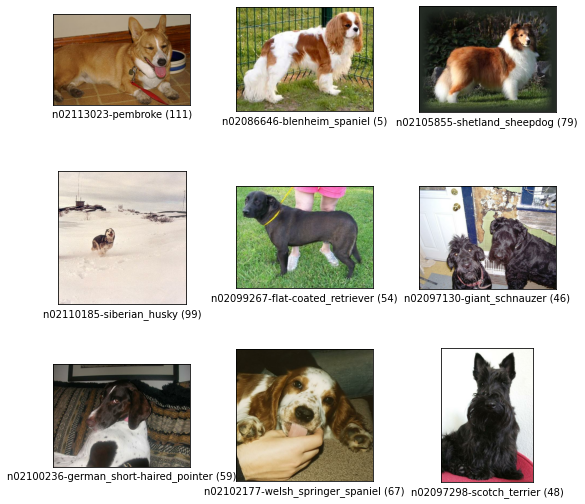

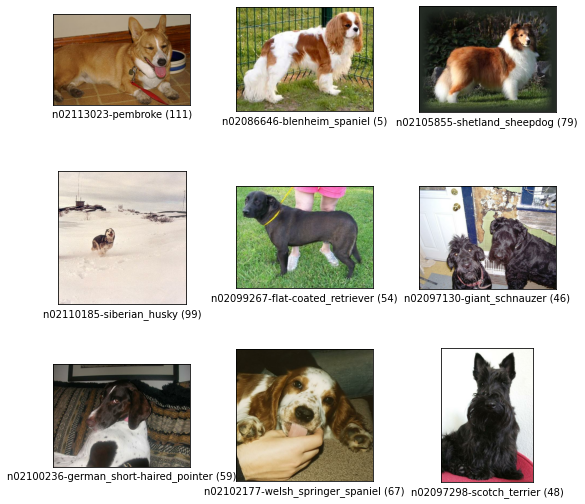

In [4]:
tfds.show_examples(ds_train, ds_info)

In [5]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [6]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [7]:
num_classes = 120
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

## 2. 모델 만들기
비교실험을 위한 모델 2개를 만든다.

### 1) CutMix
- 논문 링크 : https://arxiv.org/pdf/1905.04899.pdf

**Mixup**은 특정 비율로 픽셀별 값을 섞는 방식이고, **Cutout**은 이미지를 잘라내는 방식이다. CutMix는 Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법이다. 차에 비유하면 블렌딩 같은 방법이다.

CutMix는 이미지를 섞는 부분과 섞은 이미지에 맞추어 라벨을 섞는 부분을 포함한다. 

image_a는 배경이 되는 이미지이고 image_b는 잘라내서 합쳐지는 이미지이다.
라벨은 원 핫 벡터로 image_a에서 image_b가 차지하는 비율 만큼 곱해서 합쳐진다. 
만약에 20%를 image_b가 차지한다면 (1-0.2)xImage_a + 0.2ximage_b를 해서 구한다.

In [8]:
# CutMix

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)

    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_a의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 2) Mixup

In [9]:
# Mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image = (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [10]:
# 하이퍼파라미터
BATCH_SIZE = 16
LR = 0.005
EPOCH = 10

In [11]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_normal = apply_normalize_on_dataset(
    ds_train,
    batch_size=BATCH_SIZE,
    with_aug=False,
    with_cutmix=False,
)
ds_train_aug = apply_normalize_on_dataset(
    ds_train,
    batch_size=BATCH_SIZE,
    with_aug=True,
    with_cutmix=False,
)
ds_train_cutmix = apply_normalize_on_dataset(
    ds_train,
    batch_size=BATCH_SIZE,
    with_aug=False,
    with_cutmix=True,
)

ds_train_all = apply_normalize_on_dataset(
    ds_train,
    batch_size=BATCH_SIZE,
    with_aug=True,
    with_cutmix=True
)

ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

### 총 네가지 실험을 하였다.
1. No Augmentation, 기본 Augmentation
2. No Augmentation, CutMix만 적용
3. No Augmentation, 기본 + CutMix 적용
4. No Augmentation, mixup 적용

### 1. No Augmentation, 기본 Augmentation

In [12]:
num_classes = ds_info.features["label"].num_classes

In [13]:
# No Augmentation
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # fullyconnedted layer 포함 안함
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=LR),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/40
750/750 [==============================] - 340s 412ms/step - loss: 3.7453 - accuracy: 0.1987 - val_loss: 3.3655 - val_accuracy: 0.2224
Epoch 2/40
750/750 [==============================] - 308s 411ms/step - loss: 1.2126 - accuracy: 0.6820 - val_loss: 1.1047 - val_accuracy: 0.6763
Epoch 3/40
750/750 [==============================] - 308s 410ms/step - loss: 0.5744 - accuracy: 0.8657 - val_loss: 1.0126 - val_accuracy: 0.7051
Epoch 4/40
750/750 [==============================] - 308s 411ms/step - loss: 0.2510 - accuracy: 0.9605 - val_loss: 0.9345 - val_accuracy: 0.7252
Epoch 5/40
750/750 [==============================] - 308s 411ms/step - loss: 0.1134 - accuracy: 0.9907 - val_loss: 0.9434 - val_accuracy: 0.7234
Epoch 6/40
750/750 [==============================] - 309s 412ms/step - loss: 0.0586 - accuracy: 0.9980 - val_loss: 0.9372 - val_accuracy: 0.7242
Epoch 7/40
750/750 [==============================] - 308s 

In [15]:
import os

resnet50_path = os.getenv('HOME')+'/aiffel/GD/class_activation_map/resnet50_model.h5'
resnet50.save(resnet50_model_path)
print("저장 완료!")

저장 완료!


In [13]:
import os
resnet50_path = os.getenv('HOME')+'/aiffel/GD/class_activation_map/resnet50_model.h5'
resnet50 = tf.keras.models.load_model(resnet50_path)

In [14]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=LR),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 382s 450ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.1241 - val_accuracy: 0.7247
Epoch 2/10
750/750 [==============================] - 337s 449ms/step - loss: 0.0021 - accuracy: 0.9999 - val_loss: 1.1254 - val_accuracy: 0.7234
Epoch 3/10
750/750 [==============================] - 337s 449ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.1312 - val_accuracy: 0.7250
Epoch 4/10
750/750 [==============================] - 338s 451ms/step - loss: 0.0029 - accuracy: 0.9999 - val_loss: 1.1302 - val_accuracy: 0.7256
Epoch 5/10
750/750 [==============================] - 337s 450ms/step - loss: 0.0023 - accuracy: 0.9998 - val_loss: 1.1276 - val_accuracy: 0.7221
Epoch 6/10
750/750 [==============================] - 337s 449ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.1386 - val_accuracy: 0.7247
Epoch 7/10
750/750 [==============================] - 337s 449ms/step - loss: 0.0021 - accuracy: 0.9999 - val_loss: 1.1287 -

In [ ]:
# 기본 Augmentation
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=LR),
    metrics=['accuracy'],
)


history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

In [15]:
import os
aug_resnet50_path = os.getenv('HOME')+'/aiffel/GD/class_activation_map/aug_resnet50_model.h5'
aug_resnet50.save(aug_resnet50_path)
print("저장 완료!")

저장 완료!


In [15]:
import os
aug_resnet50_path = os.getenv('HOME')+'/aiffel/GD/class_activation_map/aug_resnet50_model.h5'
aug_resnet50 = tf.keras.models.load_model(aug_resnet50_path)

In [16]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=LR),
    metrics=['accuracy'],
)


history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 347s 450ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.0931 - val_accuracy: 0.7436
Epoch 2/10
750/750 [==============================] - 336s 448ms/step - loss: 0.0031 - accuracy: 0.9999 - val_loss: 1.0816 - val_accuracy: 0.7450
Epoch 3/10
750/750 [==============================] - 336s 448ms/step - loss: 0.0036 - accuracy: 0.9999 - val_loss: 1.0933 - val_accuracy: 0.7410
Epoch 4/10
750/750 [==============================] - 336s 449ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 1.1337 - val_accuracy: 0.7350
Epoch 5/10
750/750 [==============================] - 337s 449ms/step - loss: 0.0031 - accuracy: 0.9998 - val_loss: 1.0971 - val_accuracy: 0.7409
Epoch 6/10
750/750 [==============================] - 338s 451ms/step - loss: 0.0042 - accuracy: 0.9997 - val_loss: 1.1004 - val_accuracy: 0.7427
Epoch 7/10
750/750 [==============================] - 337s 449ms/step - loss: 0.0042 - accuracy: 0.9995 - val_loss: 1.1012 -

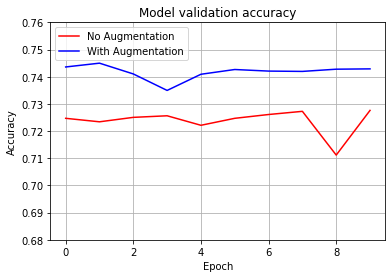

In [21]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.68, 0.76)
plt.show()

### 2. No Augmentation, CutMix만 적용

In [16]:
# CutMix적용
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=LR),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/40
750/750 [==============================] - 399s 431ms/step - loss: 4.5836 - accuracy: 0.0739 - val_loss: 3.6276 - val_accuracy: 0.1729
Epoch 2/40
750/750 [==============================] - 322s 429ms/step - loss: 3.2973 - accuracy: 0.3365 - val_loss: 1.3210 - val_accuracy: 0.6349
Epoch 3/40
750/750 [==============================] - 324s 433ms/step - loss: 2.8669 - accuracy: 0.4756 - val_loss: 1.2204 - val_accuracy: 0.6574
Epoch 4/40
750/750 [==============================] - 323s 431ms/step - loss: 2.6599 - accuracy: 0.5311 - val_loss: 1.1308 - val_accuracy: 0.6804
Epoch 5/40
750/750 [==============================] - 321s 428ms/step - loss: 2.4094 - accuracy: 0.6195 - val_loss: 1.0662 - val_accuracy: 0.7060
Epoch 7/40
750/750 [==============================] - 322s 429ms/step - loss: 2.2842 - accuracy: 0.6516 - val_loss: 1.0774 - val_accuracy: 0.6980
Epoch 8/40
750/750 [==============================] - 322s 

In [18]:
import os
cutmix_resnet50_path = os.getenv('HOME')+'/aiffel/GD/class_activation_map/cutmix_resnet50_model.h5'
cutmix_resnet50.save(cutmix_resnet50_path)
print("저장 완료!")

저장 완료!


In [18]:
import os
cutmix_resnet50_path = os.getenv('HOME')+'/aiffel/GD/class_activation_map/cutmix_resnet50_model.h5'
cutmix_resnet50 = tf.keras.models.load_model(cutmix_resnet50_path)

In [19]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=LR),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 349s 452ms/step - loss: 1.4588 - accuracy: 0.8394 - val_loss: 1.3692 - val_accuracy: 0.7067
Epoch 2/10
750/750 [==============================] - 338s 451ms/step - loss: 1.4126 - accuracy: 0.8409 - val_loss: 1.3837 - val_accuracy: 0.6980
Epoch 3/10
750/750 [==============================] - 338s 451ms/step - loss: 1.3790 - accuracy: 0.8442 - val_loss: 1.4448 - val_accuracy: 0.6937
Epoch 4/10
750/750 [==============================] - 338s 451ms/step - loss: 1.3909 - accuracy: 0.8390 - val_loss: 1.3610 - val_accuracy: 0.7102
Epoch 5/10
750/750 [==============================] - 338s 451ms/step - loss: 1.3680 - accuracy: 0.8457 - val_loss: 1.3172 - val_accuracy: 0.7079
Epoch 6/10
750/750 [==============================] - 338s 451ms/step - loss: 1.3716 - accuracy: 0.8434 - val_loss: 1.4286 - val_accuracy: 0.6919
Epoch 7/10
750/750 [==============================] - 338s 451ms/step - loss: 1.3418 - accuracy: 0.8543 - val_loss: 1.3829 -

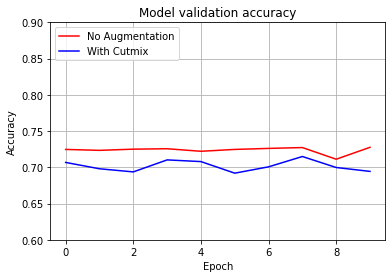

In [20]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Cutmix'], loc='upper left')
plt.grid(True)
plt.ylim(0.6, 0.9)
plt.show()

### 3. No Augmentation, 기본 + CutMix 적용

In [19]:
# 기본 + CutMix적용
cutmix2_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

cutmix2_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=LR),
    metrics=['accuracy'],
)

history_resnet50_cutmix2 = cutmix2_resnet50.fit(
    ds_train_all, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
750/750 [==============================] - 332s 430ms/step - loss: 4.6223 - accuracy: 0.0646 - val_loss: 3.2185 - val_accuracy: 0.2205
Epoch 2/40
750/750 [==============================] - 322s 429ms/step - loss: 3.3573 - accuracy: 0.3371 - val_loss: 1.4387 - val_accuracy: 0.6082
Epoch 3/40
750/750 [==============================] - 322s 429ms/step - loss: 2.9667 - accuracy: 0.4337 - val_loss: 1.4275 - val_accuracy: 0.6123
Epoch 4/40
750/750 [==============================] - 321s 428ms/step - loss: 2.7666 - accuracy: 0.4878 - val_loss: 1.1266 - val_accuracy: 0.6803
Epoch 5/40
750/750 [==============================] - 323s 431ms/step - loss: 2.6074 - accuracy: 0.5361 - val_loss: 1.0941 - val_accuracy: 0.6934
Epoch 6/40
750/750 [==============================] - 322s 430ms/step - loss: 2.5517 - accuracy: 0.5693 - val_loss: 1.0575 - val_accuracy: 0.6950
Epoch 7/40
750/750 [==============================] - 321s 428ms/step - loss: 2.4245 - accuracy: 0.5997 - val_loss: 1.0427 -

In [20]:
cutmix2_resnet50_path = os.getenv('HOME')+'/aiffel/GD/class_activation_map/cutmix2_resnet50_model.h5'
cutmix2_resnet50.save(cutmix2_resnet50_path)
print("저장 완료!")

저장 완료!


In [22]:
import os
cutmix2_resnet50_path = os.getenv('HOME')+'/aiffel/GD/class_activation_map/cutmix2_resnet50_model.h5'
cutmix2_resnet50 = tf.keras.models.load_model(cutmix2_resnet50_path)

In [23]:
cutmix2_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=LR),
    metrics=['accuracy'],
)

history_resnet50_cutmix2 = cutmix2_resnet50.fit(
    ds_train_all, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 349s 451ms/step - loss: 1.5205 - accuracy: 0.8183 - val_loss: 1.2952 - val_accuracy: 0.6966
Epoch 2/10
750/750 [==============================] - 345s 460ms/step - loss: 1.5117 - accuracy: 0.8207 - val_loss: 1.1610 - val_accuracy: 0.7238
Epoch 3/10
750/750 [==============================] - 337s 450ms/step - loss: 1.5264 - accuracy: 0.8187 - val_loss: 1.1837 - val_accuracy: 0.7208
Epoch 4/10
750/750 [==============================] - 336s 448ms/step - loss: 1.4861 - accuracy: 0.8273 - val_loss: 1.2518 - val_accuracy: 0.7135
Epoch 5/10
750/750 [==============================] - 337s 450ms/step - loss: 1.5036 - accuracy: 0.8198 - val_loss: 1.2280 - val_accuracy: 0.7172
Epoch 6/10
750/750 [==============================] - 336s 448ms/step - loss: 1.4727 - accuracy: 0.8317 - val_loss: 1.2046 - val_accuracy: 0.7212
Epoch 7/10
750/750 [==============================] - 336s 449ms/step - loss: 1.4777 - accuracy: 0.8224 - val_loss: 1.1826 -

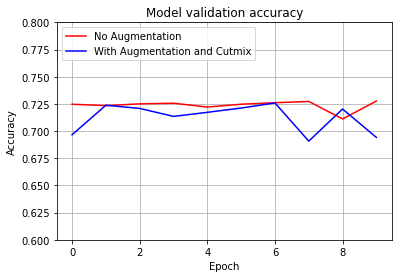

In [40]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_cutmix2.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation and Cutmix'], loc='upper left')
plt.grid(True)
plt.ylim(0.6, 0.8)
plt.show()

### 4. No Augmentation, mixup 적용

apply_normalize_on_dataset은 mixup의 사용을 고려하지 않았기 때문에 mixup의 사용을 고려한 apply_normalize_on_dataset2를 만들어준다.

In [27]:
def apply_normalize_on_dataset2(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [28]:
ds_train_mixup = apply_normalize_on_dataset2(
    ds_train,
    batch_size=BATCH_SIZE,
    with_aug=False,
    with_cutmix=False,
    with_mixup=True
)

In [23]:
# Mixup적용
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=LR),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/40
750/750 [==============================] - 333s 430ms/step - loss: 4.5536 - accuracy: 0.0838 - val_loss: 3.8825 - val_accuracy: 0.1343
Epoch 2/40
750/750 [==============================] - 322s 429ms/step - loss: 3.1578 - accuracy: 0.3981 - val_loss: 1.3590 - val_accuracy: 0.6158
Epoch 3/40
750/750 [==============================] - 323s 431ms/step - loss: 2.7718 - accuracy: 0.5133 - val_loss: 1.2613 - val_accuracy: 0.6420
Epoch 4/40
750/750 [==============================] - 322s 430ms/step - loss: 2.5589 - accuracy: 0.6026 - val_loss: 1.2096 - val_accuracy: 0.6676
Epoch 5/40
750/750 [==============================] - 321s 429ms/step - loss: 2.4414 - accuracy: 0.6469 - val_loss: 1.1327 - val_accuracy: 0.6799
Epoch 6/40
750/750 [==============================] - 319s 426ms/step - loss: 2.3221 - accuracy: 0.6923 - val_loss: 1.1339 - val_accuracy: 0.6862
Epoch 7/40
750/750 [==============================] - 324s 432ms/step - loss: 2.2242 - accuracy: 0.7325 - val_loss: 1.0835 -

In [25]:
mixup_resnet50_path = os.getenv('HOME')+'/aiffel/GD/class_activation_map/mixup_resnet50_model.h5'
mixup_resnet50.save(mixup_resnet50_path)
print("저장 완료!")

저장 완료!


In [25]:
import os
mixup_resnet50_path = os.getenv('HOME')+'/aiffel/GD/class_activation_map/mixup_resnet50_model.h5'
mixup_resnet50 = tf.keras.models.load_model(mixup_resnet50_path)

In [29]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=LR),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 345s 448ms/step - loss: 1.5947 - accuracy: 0.8867 - val_loss: 1.2765 - val_accuracy: 0.6923
Epoch 2/10
750/750 [==============================] - 337s 449ms/step - loss: 1.5773 - accuracy: 0.8874 - val_loss: 1.2681 - val_accuracy: 0.7045
Epoch 3/10
750/750 [==============================] - 338s 450ms/step - loss: 1.5712 - accuracy: 0.8917 - val_loss: 1.3410 - val_accuracy: 0.6747
Epoch 4/10
750/750 [==============================] - 336s 448ms/step - loss: 1.5497 - accuracy: 0.8921 - val_loss: 1.3195 - val_accuracy: 0.6899
Epoch 5/10
750/750 [==============================] - 337s 449ms/step - loss: 1.5556 - accuracy: 0.8962 - val_loss: 1.2917 - val_accuracy: 0.7009
Epoch 6/10
750/750 [==============================] - 338s 451ms/step - loss: 1.5480 - accuracy: 0.8847 - val_loss: 1.3148 - val_accuracy: 0.6911
Epoch 7/10
750/750 [==============================] - 338s 451ms/step - loss: 1.5544 - accuracy: 0.8810 - val_loss: 1.3461 -

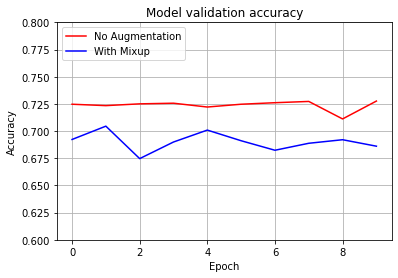

<Figure size 720x1080 with 0 Axes>

In [33]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.6, 0.8)
plt.figure(figsize=(10,15))
plt.show()

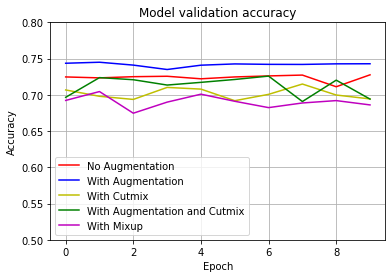

<Figure size 720x864 with 0 Axes>

In [39]:

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_cutmix2.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation','With Augmentation','With Cutmix','With Augmentation and Cutmix', 'With Mixup'], loc='lower left')
plt.grid(True)
plt.ylim(0.5, 0.8)
plt.figure(figsize=(10, 12))
plt.show()

## 회고
- epoch = 25로 했을 때, 오히려 기본 augmentation이 cutmix나 mixup보다 성능이 좋은 것으로 보인다.
- epoch 40으로 하면 중간에 끊길 것 같아서 가중치를 저장하도록 해놨다.
- 그 다음에 epoch 10으로 해서 결과를 비교했다.

### 1. Epoch 20으로 했을 때
|No Augmentation, 기본 Augmentation|No Augmentation, With cutmix|No Augmentation, With Augmentation and Cutmix|No Augmentation, Mixup|
|---|---|---|---|
|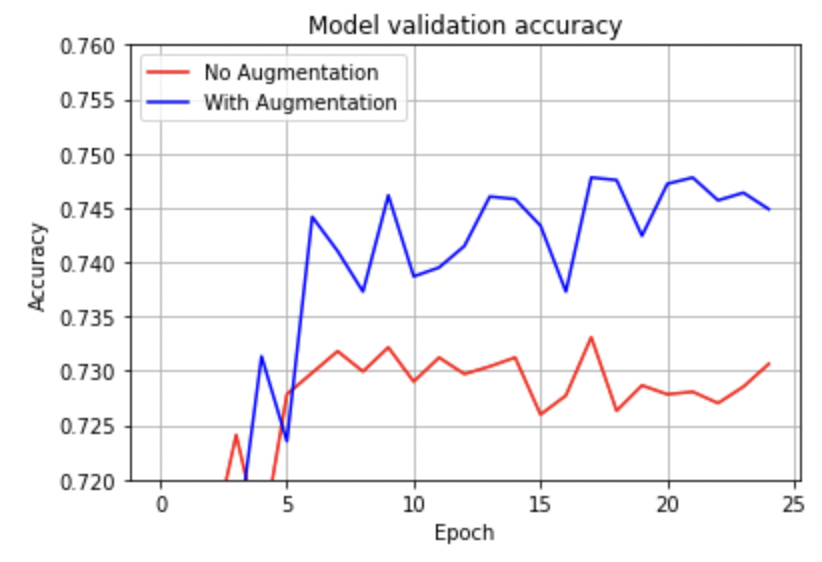|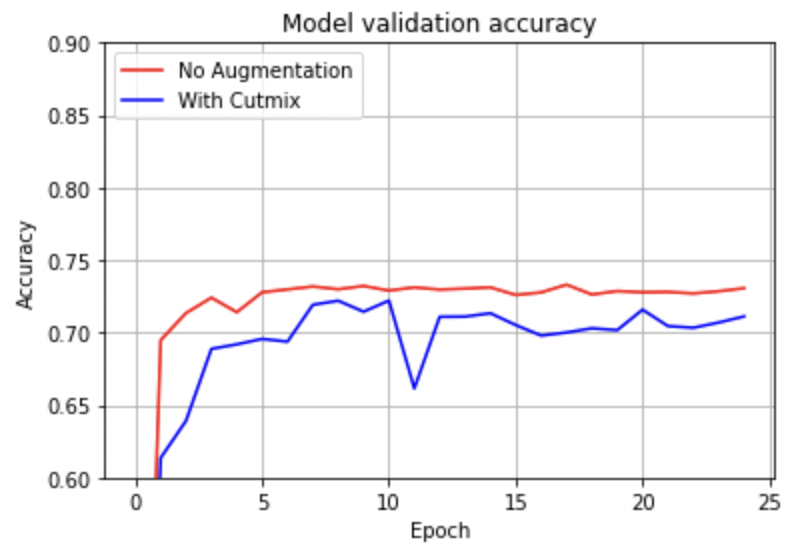|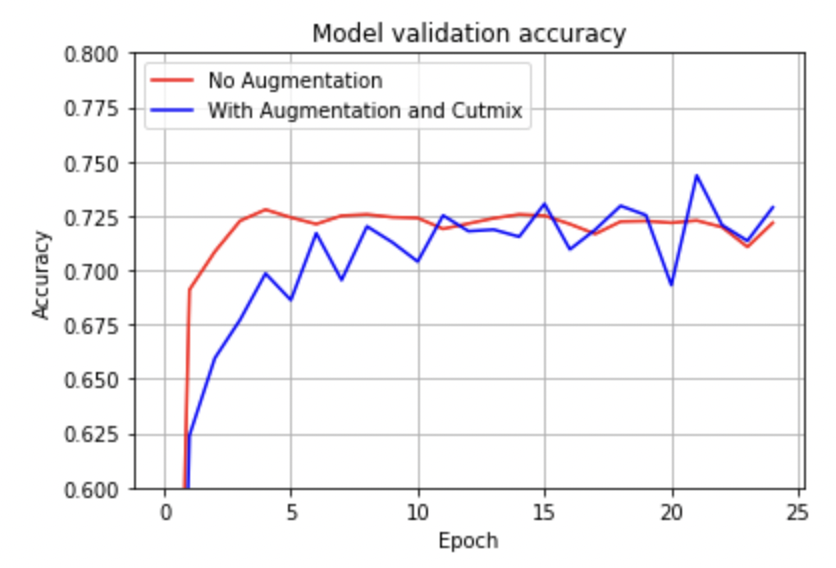|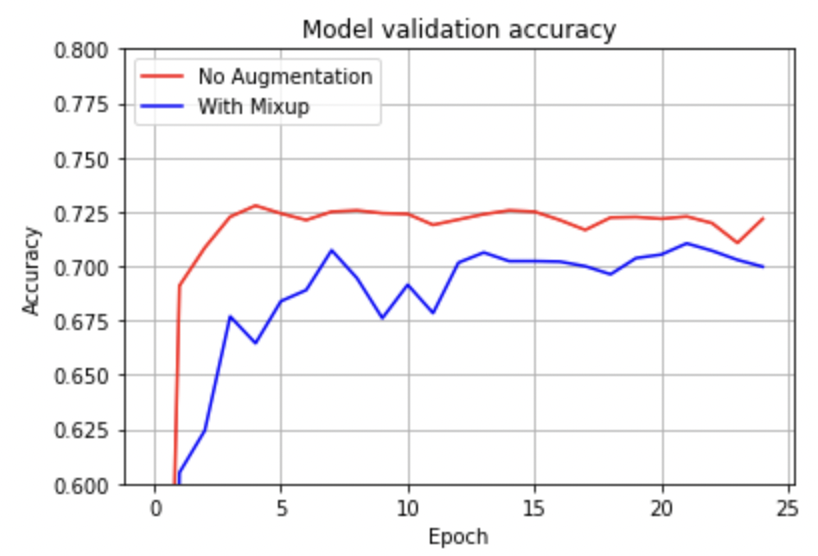|

### 2. Epoch 40으로 훈련한 가중치에 Epoch 10을 한 결과
|No Augmentation, 기본 Augmentation|No Augmentation, With cutmix|No Augmentation, With Augmentation and Cutmix|No Augmentation, Mixup|
|---|---|---|---|
|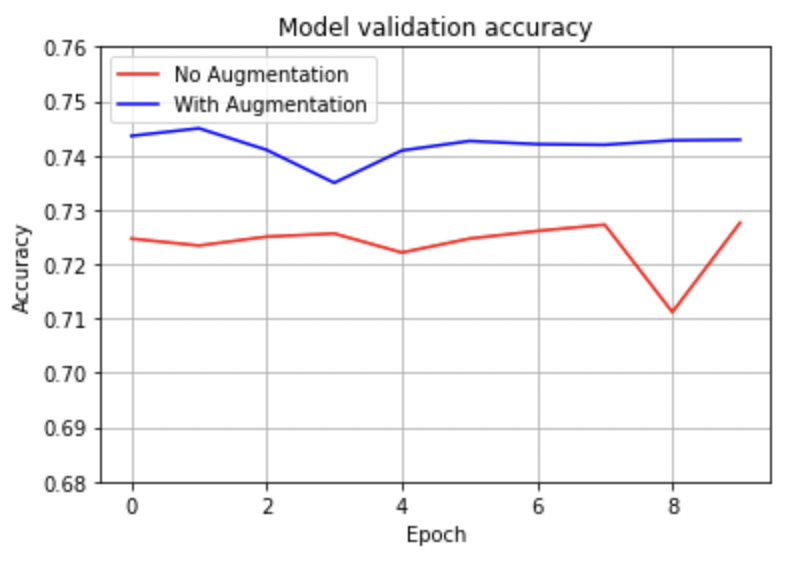|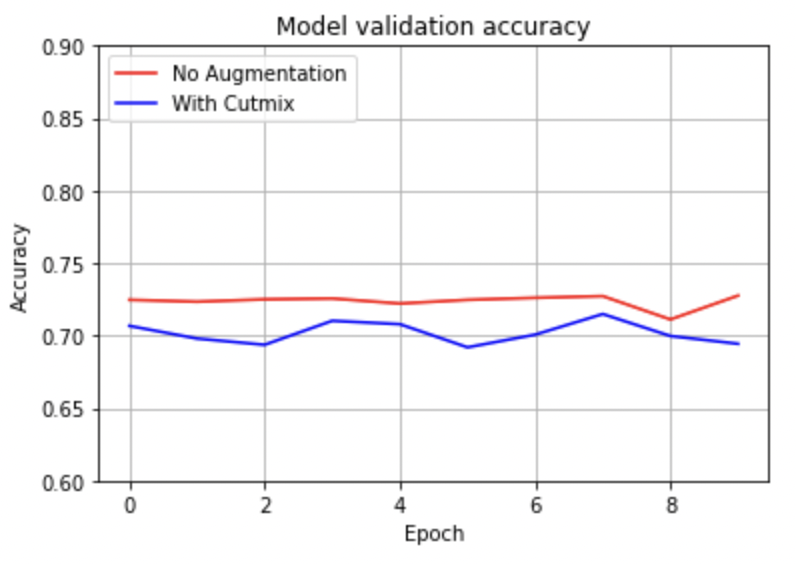|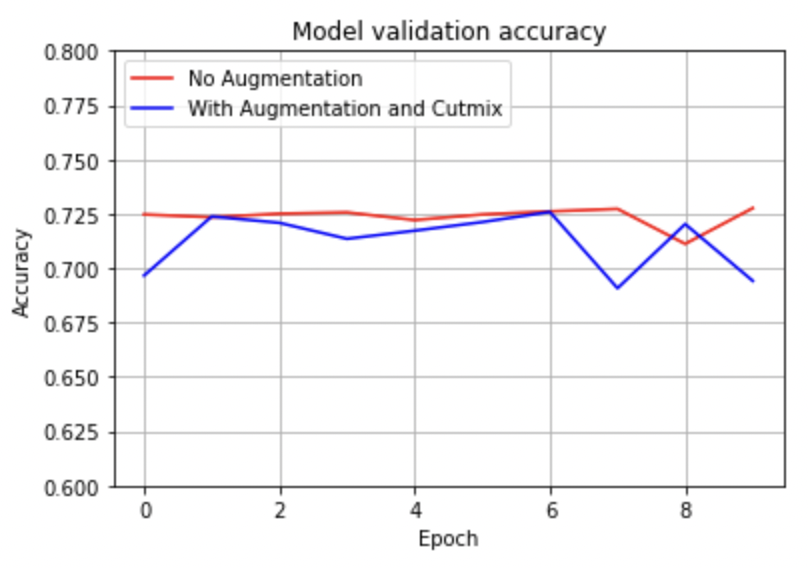|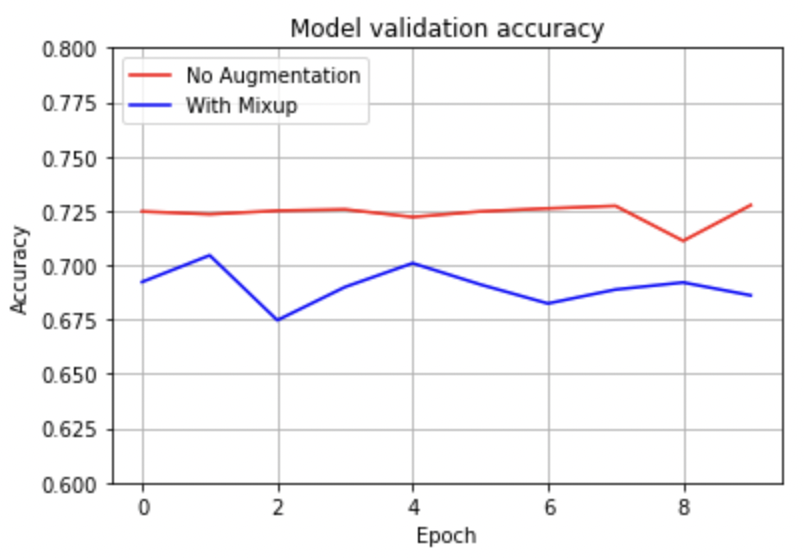|

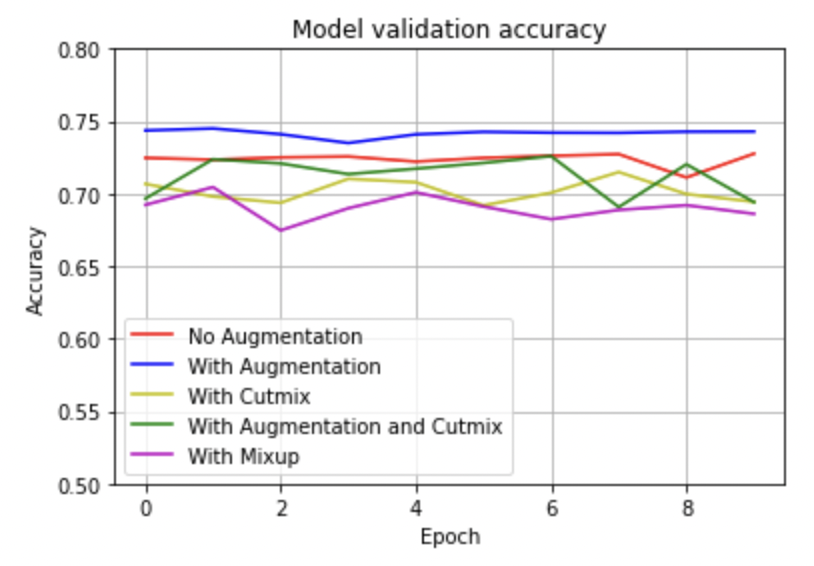

### 결과
- no-augmentation보다 mixup이나 cutmix를 했을 때 accuracy가 더 좋아질 것이라고 생각했다.
- 처음에 epoch 20까지 했을 때 결과가 좋지않아 epoch를 늘렸다.
- 하지만 epoch 50까지 했을 때도 기대했던 결과가 나오지 않았다. 아마도 epoch를 훨씬 많이 해야 되거나, 더 많은 데이터셋을 가지고 해야할 것 같다.
- epoch 50만 했을 때는 기본 augmentation > No augmentation > 기본 augmentation + cutmix > cutmix > mixup 순으로 성능이 좋았다.